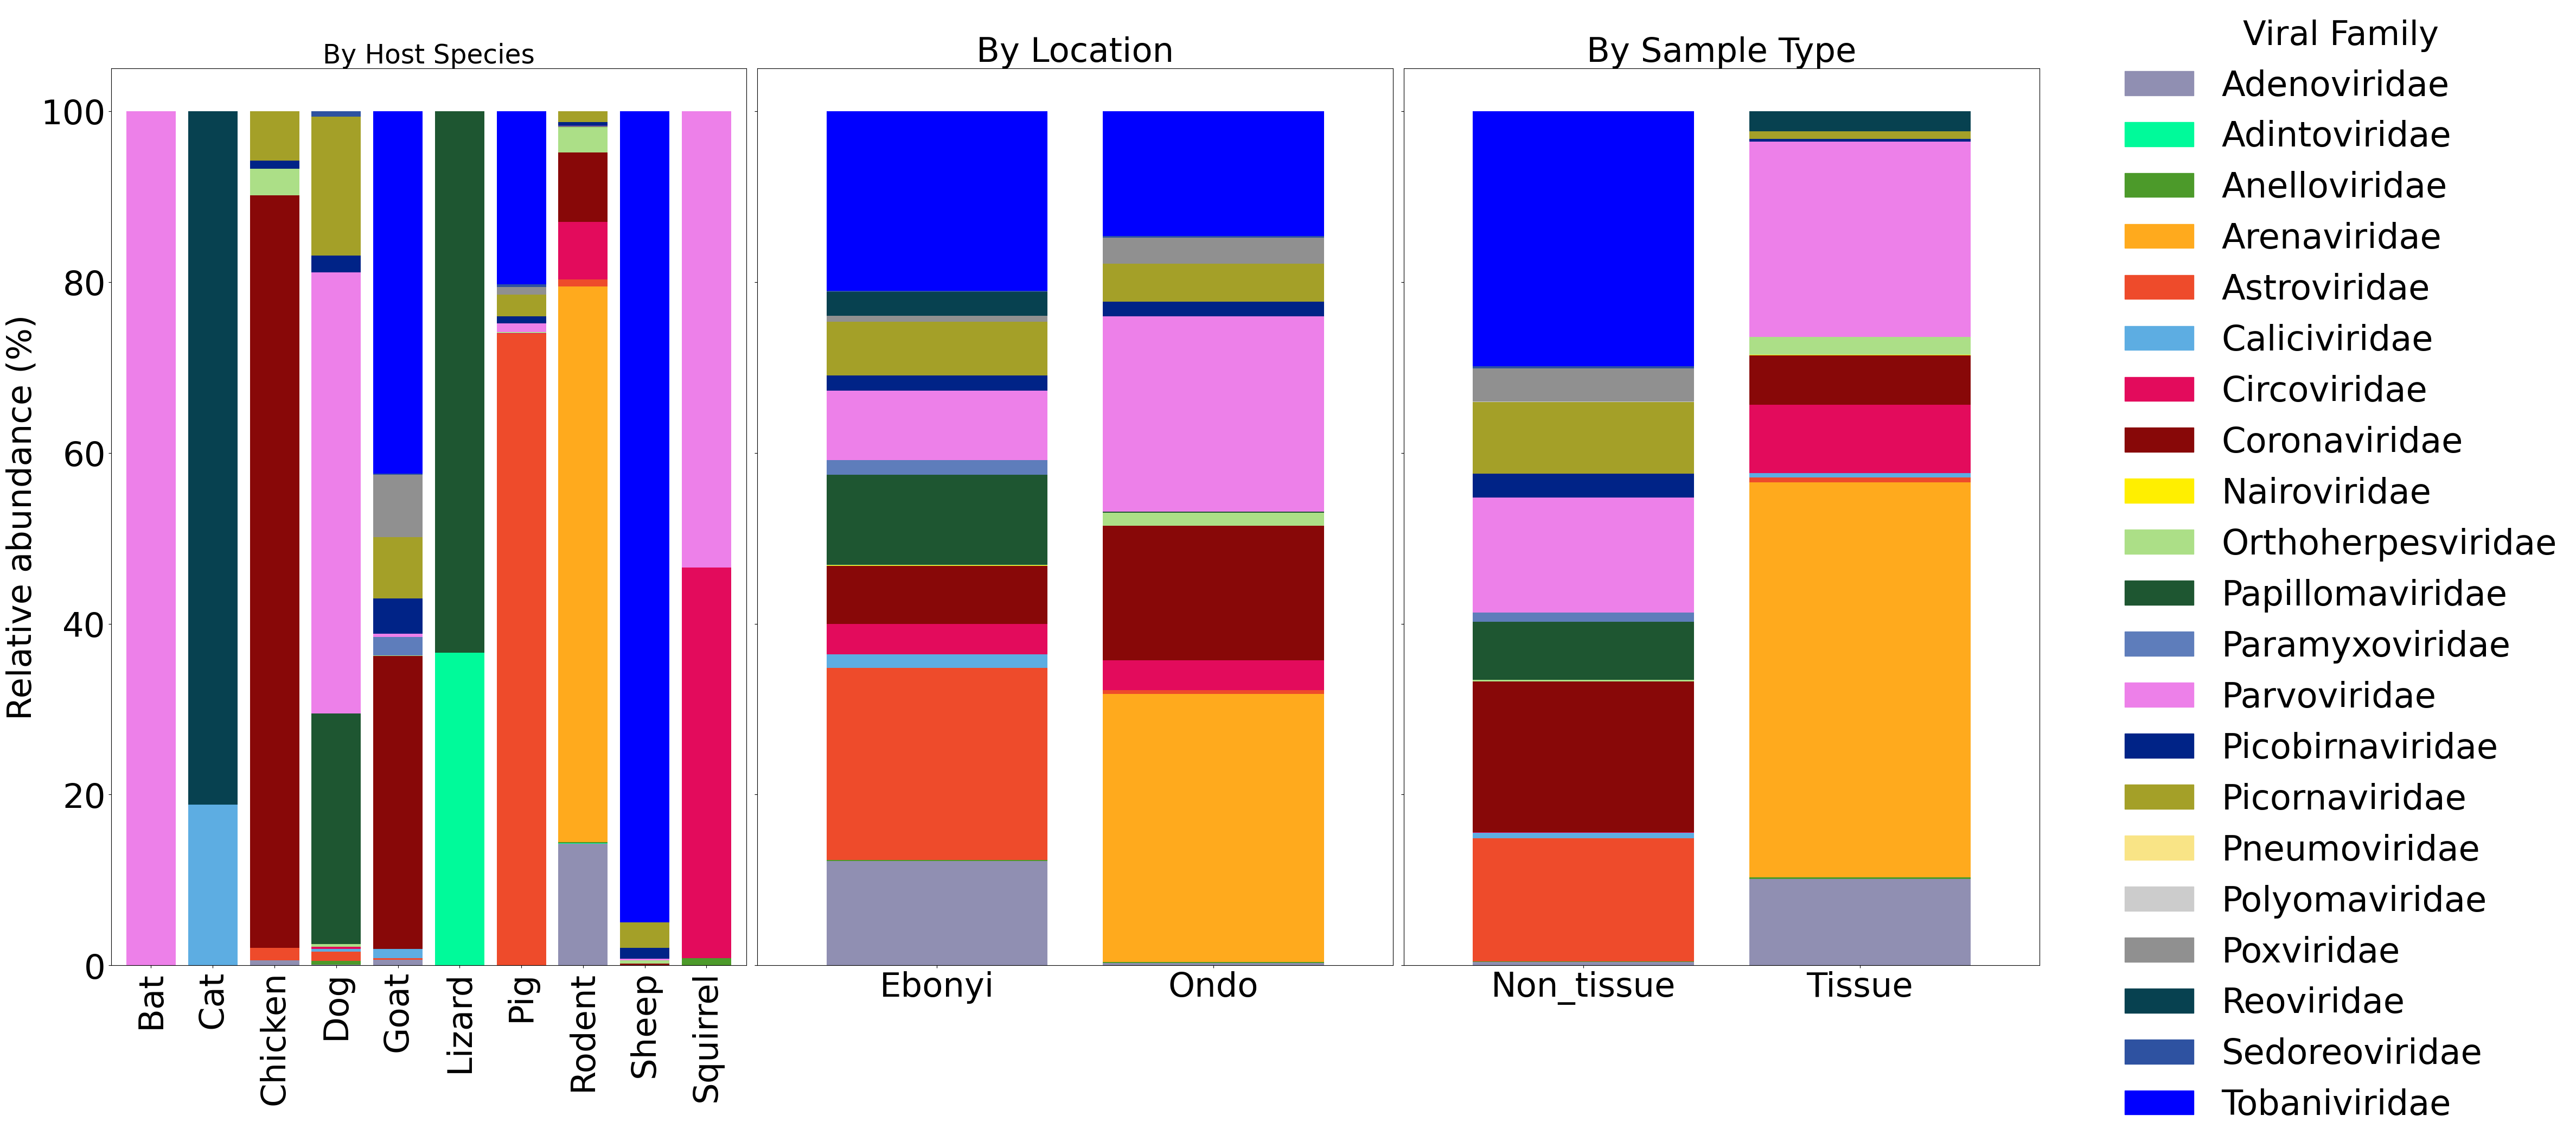

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# 0. Load the custom color palette
palette = pd.read_csv('./fig3_color_palette.txt', sep='\s+', engine='python')
color_map = dict(zip(palette['key'], palette['color']))

# 1. Load & filter your data
df = pd.read_csv('./Virus_abundance_Vertebrate_only_with_summary.csv')
df = df[df['rpm'] >= 1]

# 2A. Summarize by host species
spec = (
    df
    .groupby(['ska_species', 'family'], as_index=False)
    .agg(total_RPM=('rpm', 'sum'))
)
pivot_spec = spec.pivot(index='ska_species', columns='family', values='total_RPM').fillna(0)
rel_spec   = pivot_spec.div(pivot_spec.sum(axis=1), axis=0) * 100

# 2B. Summarize by location
loc = (
    df
    .groupby(['collected_by', 'family'], as_index=False)
    .agg(total_RPM=('rpm', 'sum'))
)
pivot_loc = loc.pivot(index='collected_by', columns='family', values='total_RPM').fillna(0)
rel_loc   = pivot_loc.div(pivot_loc.sum(axis=1), axis=0) * 100

# 2C. Summarize by sample type
stype = (
    df
    .groupby(['sample_type', 'family'], as_index=False)
    .agg(total_RPM=('rpm', 'sum'))
)
pivot_stype = stype.pivot(index='sample_type', columns='family', values='total_RPM').fillna(0)
rel_stype   = pivot_stype.div(pivot_stype.sum(axis=1), axis=0) * 100

# 3. Build a list of colors matching the order of families
families = rel_spec.columns.tolist()
colors    = [color_map.get(fam, '#CCCCCC') for fam in families]

# 4. Create a 1×3 subplot grid
fig, axes = plt.subplots(1, 3, figsize=(42, 20), sharey=True)

# Add light grid lines
for ax in axes:
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='gray', linestyle='--', linewidth=0.5)

# 5A. Plot: by host species
rel_spec.plot(
    kind='bar', stacked=True,
    ax=axes[0], color=colors, width=0.8, legend=False
)
axes[0].set_title('By Host Species', fontsize=35)
axes[0].set_xlabel('', fontsize=18)
axes[0].set_ylabel('Relative abundance (%)', fontsize=45)
axes[0].tick_params(axis='x', labelrotation=90, labelsize=45)
axes[0].tick_params(axis='y', labelsize=45)


# 5C. Plot: by sample type
rel_stype[families].plot(
    kind='bar', stacked=True,
    ax=axes[2], color=colors, width=0.8, legend=False
)
axes[2].set_title('By Sample Type', fontsize=45)
axes[2].set_xlabel('', fontsize=45)
axes[2].tick_params(axis='x', labelrotation=0, labelsize=45)
axes[2].tick_params(axis='y', labelsize=45)


# 5B. Plot: by location
rel_loc[families].plot(
    kind='bar', stacked=True,
    ax=axes[1], color=colors, width=0.8, legend=False
)
axes[1].set_title('By Location', fontsize=45)
axes[1].set_xlabel('', fontsize=35)
axes[1].tick_params(axis='x', labelrotation=0, labelsize=45)
axes[1].tick_params(axis='y', labelsize=45)


# 6. Shared legend on the right
handles = [plt.Rectangle((0,0),1,1, color=col) for col in colors]
labels  = families
fig.legend(
    handles, labels,
    title='Viral Family',
    title_fontsize=45,
    fontsize=46,
    bbox_to_anchor=(0.92, 0.5),
    loc='center left',
    frameon=False
)

plt.tight_layout(rect=[0, 0, 0.90, 1])
plt.savefig("Virus_Relative_host_loc_type.png", dpi=300, bbox_inches="tight")
plt.savefig("Virus_Relative_host_loc_type.svg", dpi=300, bbox_inches="tight")
plt.show()

In [2]:
import pandas as pd

# ----------------------------------------
# 1) Load the CSV into a DataFrame
# ----------------------------------------
df = pd.read_csv("./edited_DNA_RNA_vertebrate_only_counts.csv",
    dtype={
        "family": str,
        "sample": str,
        "contig_name": str,
        "name": str,
        "Hosts": str,
        "collected_by": str,
        "read_count": float,
        "sampletype": str,
        "identity": float,
        "sample_type": str
    }
)

# Trim whitespace from Host and Virus columns
df["Host"]  = df["Hosts"].str.strip()
df["Virus"] = df["name"].str.strip()

# ----------------------------------------
# 2) Build unique Host–Virus pairs
# ----------------------------------------
host_virus_pairs = (
    df[["Host", "Virus"]]
      .drop_duplicates()
      .reset_index(drop=True)
)

# ----------------------------------------
# 3) For every virus, collect the *list* of hosts and host count
# ----------------------------------------
virus_to_hosts = (
    host_virus_pairs
      .groupby("Virus")["Host"]
      .apply(lambda s: sorted(s.unique()))     # <- list of hosts
      .to_dict()
)

virus_host_counts = (
    host_virus_pairs
      .groupby("Virus")["Host"]
      .nunique()
      .reset_index(name="n_hosts")
)

# ----------------------------------------
# 4) Build virus → family dictionary
# ----------------------------------------
virus_to_family = (
    df[["Virus", "family"]]
      .drop_duplicates("Virus")
      .set_index("Virus")["family"]
      .to_dict()
)

# ----------------------------------------
# 5) Build virus → sorted list of locations dictionary
# ----------------------------------------
virus_to_locations = (
    df.groupby("Virus")["collected_by"]
      .unique()
      .apply(lambda arr: sorted(arr))
      .to_dict()
)

# ----------------------------------------
# 6) Assemble the summary DataFrame
# ----------------------------------------
virus_summary = virus_host_counts.copy()
virus_summary["family"]    = virus_summary["Virus"].map(virus_to_family)
virus_summary["hosts"]     = virus_summary["Virus"].map(
    lambda v: ";".join(virus_to_hosts.get(v, []))
)
virus_summary["locations"] = virus_summary["Virus"].map(
    lambda v: ";".join(virus_to_locations.get(v, []))
)
virus_summary["co_occurrence"] = virus_summary["locations"].apply(
    lambda s: len(s.split(";")) > 1
)

# ----------------------------------------
# 7) For each target number of hosts (2–6), extract viruses and write files
# ----------------------------------------
for n in range(2, 7):
    viruses_n = virus_summary[virus_summary["n_hosts"] == n].copy()
    
    print(f"\nViruses infecting exactly {n} hosts: {len(viruses_n)}")
    print(
        viruses_n[
            ["Virus", "family", "hosts", "locations", "co_occurrence"]
        ].head(10)
    )
    
    # Write summary (with host list) to CSV
    viruses_n.to_csv(f"./viruses_in_exactly_{n}_hosts_summary.csv", index=False)
    
    # ----------------------------------------
    # 8) (Optional) full sample-level details with host list
    # ----------------------------------------
    df_nhosts = df[df["Virus"].isin(viruses_n["Virus"])]
    df_nhosts = df_nhosts.merge(
        viruses_n[["Virus", "family", "hosts", "locations", "co_occurrence"]],
        on="Virus",
        how="left"
    )
    df_nhosts.to_csv(
        f"./viruses_in_exactly_{n}_hosts_full_details.csv",
        index=False
    )



Viruses infecting exactly 2 hosts: 41
                      Virus              family            hosts  \
4            Anativirus sp.      Picornaviridae       Dog;Rodent   
5         Anelloviridae sp.       Anelloviridae  Rodent;Squirrel   
8      Astrovirus wild boar        Astroviridae       Pig;Rodent   
14          Betacoronavirus       Coronaviridae       Goat;Sheep   
19  Bovine gammaherpesvirus  Orthoherpesviridae        Pig;Sheep   
25              Breda virus       Tobaniviridae       Goat;Sheep   
26   Canid alphaherpesvirus  Orthoherpesviridae       Dog;Rodent   
28         Canine kobuvirus      Picornaviridae         Dog;Goat   
38       Chicken astrovirus        Astroviridae     Chicken;Goat   
43           Circovirus sp.        Circoviridae       Pig;Rodent   

         locations  co_occurrence  
4             Ondo          False  
5       Ondo;Ondo            True  
8      Ebonyi;Ondo           True  
14     Ebonyi;Ondo           True  
19  Ebonyi;Ebonyi            Tru

In [4]:
import pandas as pd

# ----------------------------------------
# 1) Load the CSV into a DataFrame
# ----------------------------------------
df = pd.read_csv(
    "./edited_DNA_RNA_vertebrate_only_counts.csv",
    dtype={
        "family": str,
        "sample": str,
        "contig_name": str,
        "name": str,
        "Hosts": str,
        "collected_by": str,
        "read_count": float,
        "sampletype": str,
        "identity": float,
        "sample_type": str
    }
)

# Trim whitespace from Host and Virus columns
df["Host"] = df["Hosts"].str.strip()
df["Virus"] = df["name"].str.strip()

# ----------------------------------------
# 2) Build a unique Host–Virus presence table
# ----------------------------------------
host_virus_pairs = (
    df[["Host", "Virus"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

# ----------------------------------------
# 3) Count how many distinct Hosts each Virus infects
# ----------------------------------------
virus_host_counts = (
    host_virus_pairs
    .groupby("Virus")["Host"]
    .nunique()
    .reset_index(name="n_hosts")
)

# ----------------------------------------
# 4) For each target number of hosts (2 through 6), extract the virus list
# ----------------------------------------
viruses_by_host_count = {}
for n in range(2, 7):
    viruses_n = virus_host_counts.query("n_hosts == @n")["Virus"].tolist()
    viruses_by_host_count[n] = viruses_n
    print(f"Viruses infecting exactly {n} hosts: {len(viruses_n)}")

# ----------------------------------------
# 5) (Optional) Print a few examples for each category
# ----------------------------------------
for n in range(2, 7):
    example_list = sorted(viruses_by_host_count[n])[:10]
    print(f"\n-- Examples of viruses infecting exactly {n} hosts --")
    print(example_list)

# ----------------------------------------
# 6) (Optional) Write full details for each category to separate CSVs
#    (Here we save all rows from the original df for those viruses.)
# ----------------------------------------
for n in range(2, 7):
    virus_list = viruses_by_host_count[n]
    df_nhosts = df[df["Virus"].isin(virus_list)]
    df_nhosts.to_csv(
        f"./viruses_in_exactly_{n}_hosts_full_details.csv",
        index=False
    )

Viruses infecting exactly 2 hosts: 41
Viruses infecting exactly 3 hosts: 9
Viruses infecting exactly 4 hosts: 5
Viruses infecting exactly 5 hosts: 2
Viruses infecting exactly 6 hosts: 1

-- Examples of viruses infecting exactly 2 hosts --
['Anativirus sp.', 'Anelloviridae sp.', 'Astrovirus wild boar', 'Betacoronavirus', 'Bovine gammaherpesvirus', 'Breda virus', 'Canid alphaherpesvirus', 'Canine kobuvirus', 'Chicken astrovirus', 'Circovirus sp.']

-- Examples of viruses infecting exactly 3 hosts --
['Adeno-associated virus', 'Canine parvovirus', 'Chicken picornavirus', 'Circovirus gnaver', 'Human papillomavirus', 'Mamastrovirus sp.', 'Marmot picobirnavirus', 'Picornavirales sp.', 'Sicinivirus sp.']

-- Examples of viruses infecting exactly 4 hosts --
['Bovine picobirnavirus', 'Dromedary picobirnavirus', 'Human rotavirus A', 'Infectious bronchitis virus', 'Rotavirus A']

-- Examples of viruses infecting exactly 5 hosts --
['Porcine picobirnavirus', 'megrivirus C2']

-- Examples of viruse

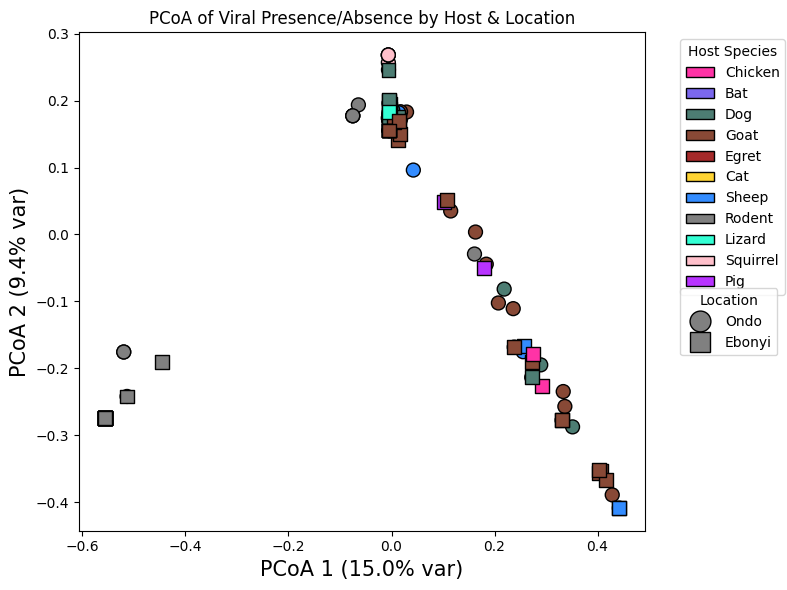

PERMANOVA by Host Species:
 method name               PERMANOVA
test statistic name        pseudo-F
sample size                     118
number of groups                 10
test statistic             3.264153
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object 

PERMANOVA by Location:
 method name               PERMANOVA
test statistic name        pseudo-F
sample size                     118
number of groups                  2
test statistic             2.869908
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object 



In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA
from skbio.stats.distance import DistanceMatrix, permanova

# ─── 0) Config ──────────────────────────────────────────────────────────────────
HOST_COLORS = {
    "Chicken":  "#FF33A6",
    "Bat":      "#7B68EE",
    "Dog":      "#4D7D73",
    "Goat":     "#884936",
    "Egret":    "#A52A2A",
    "Cat":      "#FFD433",
    "Sheep":    "#338CFF",
    "Rodent":   "grey",
    "Lizard":   "#33FFD4",
    "Squirrel": "#FFC0CB",
    "Pig":      "#B833FF"
}

MARKER_MAP = {"Ondo": "o", "Ebonyi": "s"}
CSV = "./Virus_abundance_Vertebrate_only_with_summary.csv"
RPM_MIN = 1

# ─── 1) Load & Filter ───────────────────────────────────────────────────────────
df = pd.read_csv(CSV)
df = df[df["rpm"] >= RPM_MIN].copy()

# ─── 2) Presence/Absence by virus sci_name ──────────────────────────────────────
# If a sample has no viruses after filtering, it'll be dropped in step 2b.
mat = (
    df.groupby(["sample", "sci_name"])["total_RPM"]
      .sum()
      .unstack(fill_value=0)
)

# 2a) Binary presence/absence
mat = (mat > 0).astype(int)

# 2b) Drop all-zero rows (samples with no viruses after filtering)
nonzero = mat.sum(axis=1) > 0
mat = mat.loc[nonzero]

# ─── 3) Bray–Curtis distance ────────────────────────────────────────────────────
def bray_curtis(u, v):
    denom = np.sum(u + v)
    if denom == 0:
        return 0.0  # should not occur after nonzero filter, but safe-guard
    return np.sum(np.abs(u - v)) / denom

n = mat.shape[0]
D = np.zeros((n, n), dtype=float)
vals = mat.values
for i in range(n):
    for j in range(n):
        D[i, j] = bray_curtis(vals[i], vals[j])

# ─── 4) Classical PCoA (from distance) ──────────────────────────────────────────
H = np.eye(n) - np.ones((n, n)) / n
B = -0.5 * H.dot(D**2).dot(H)

eigvals, eigvecs = np.linalg.eigh(B)
order = np.argsort(eigvals)[::-1]
eigvals = eigvals[order]
eigvecs = eigvecs[:, order]

# Numerical guard: clip tiny negatives before sqrt
eigvals_clipped = np.clip(eigvals, a_min=0, a_max=None)
coords = eigvecs[:, :2] * np.sqrt(eigvals_clipped[:2, np.newaxis]).T

var_explained = eigvals_clipped / eigvals_clipped.sum() * 100 if eigvals_clipped.sum() > 0 else np.zeros_like(eigvals_clipped)
pc1_pct, pc2_pct = (var_explained[0], var_explained[1]) if len(var_explained) >= 2 else (0.0, 0.0)

# ─── 5) Metadata (per-sample) ───────────────────────────────────────────────────
meta = (
    df[["sample", "ska_species", "collected_by"]]
      .drop_duplicates(subset="sample")
      .set_index("sample")
      .reindex(mat.index)   # align to P/A matrix samples
)

species_lbl = meta["ska_species"]
locations   = meta["collected_by"]

# ─── 6) Plot PCoA ───────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 6))

for loc, marker in MARKER_MAP.items():
    idx = (locations == loc).fillna(False).values
    if not np.any(idx):
        continue
    color_list = [
        HOST_COLORS.get(h, "#666666")
        for h in species_lbl[idx].fillna("Unknown")
    ]
    ax.scatter(
        coords[idx, 0],
        coords[idx, 1],
        c=color_list,
        marker=marker,
        s=100,
        edgecolor="k",
        label=loc
    )

ax.set_xlabel(f"PCoA 1 ({pc1_pct:.1f}% var)", size=15)
ax.set_ylabel(f"PCoA 2 ({pc2_pct:.1f}% var)", size=15)
ax.set_title("PCoA of Viral Presence/Absence by Host & Location")

# Legend: host species
species_handles = [Patch(facecolor=clr, edgecolor="k") for clr in HOST_COLORS.values()]
species_labels  = list(HOST_COLORS.keys())
legend_hosts = ax.legend(
    species_handles,
    species_labels,
    title="Host Species",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)

# Legend: locations
marker_handles = [
    Line2D([0], [0], marker=m, color="w", markerfacecolor="grey",
           markeredgecolor="k", markersize=15, linestyle="None")
    for m in MARKER_MAP.values()
]
marker_labels = list(MARKER_MAP.keys())
legend_locs = ax.legend(
    marker_handles,
    marker_labels,
    title="Location",
    bbox_to_anchor=(1.05, 0.5),
    loc="upper left"
)
ax.add_artist(legend_hosts)

plt.tight_layout()
plt.savefig("PCoA_presence_absence.svg", dpi=300, bbox_inches="tight")
plt.show()

# ─── 7) PERMANOVA (use per-sample factor: host species) ─────────────────────────
sample_ids = mat.index.tolist()
bc_dm = DistanceMatrix(D, ids=sample_ids)
meta_for_adonis = meta.loc[sample_ids]

res_host = permanova(
    distance_matrix=bc_dm,
    grouping=meta_for_adonis["ska_species"],
    permutations=999
)
print("PERMANOVA by Host Species:\n", res_host, "\n")

# Optional: also test by collection location
res_loc = permanova(
    distance_matrix=bc_dm,
    grouping=meta_for_adonis["collected_by"],
    permutations=999
)
print("PERMANOVA by Location:\n", res_loc, "\n")



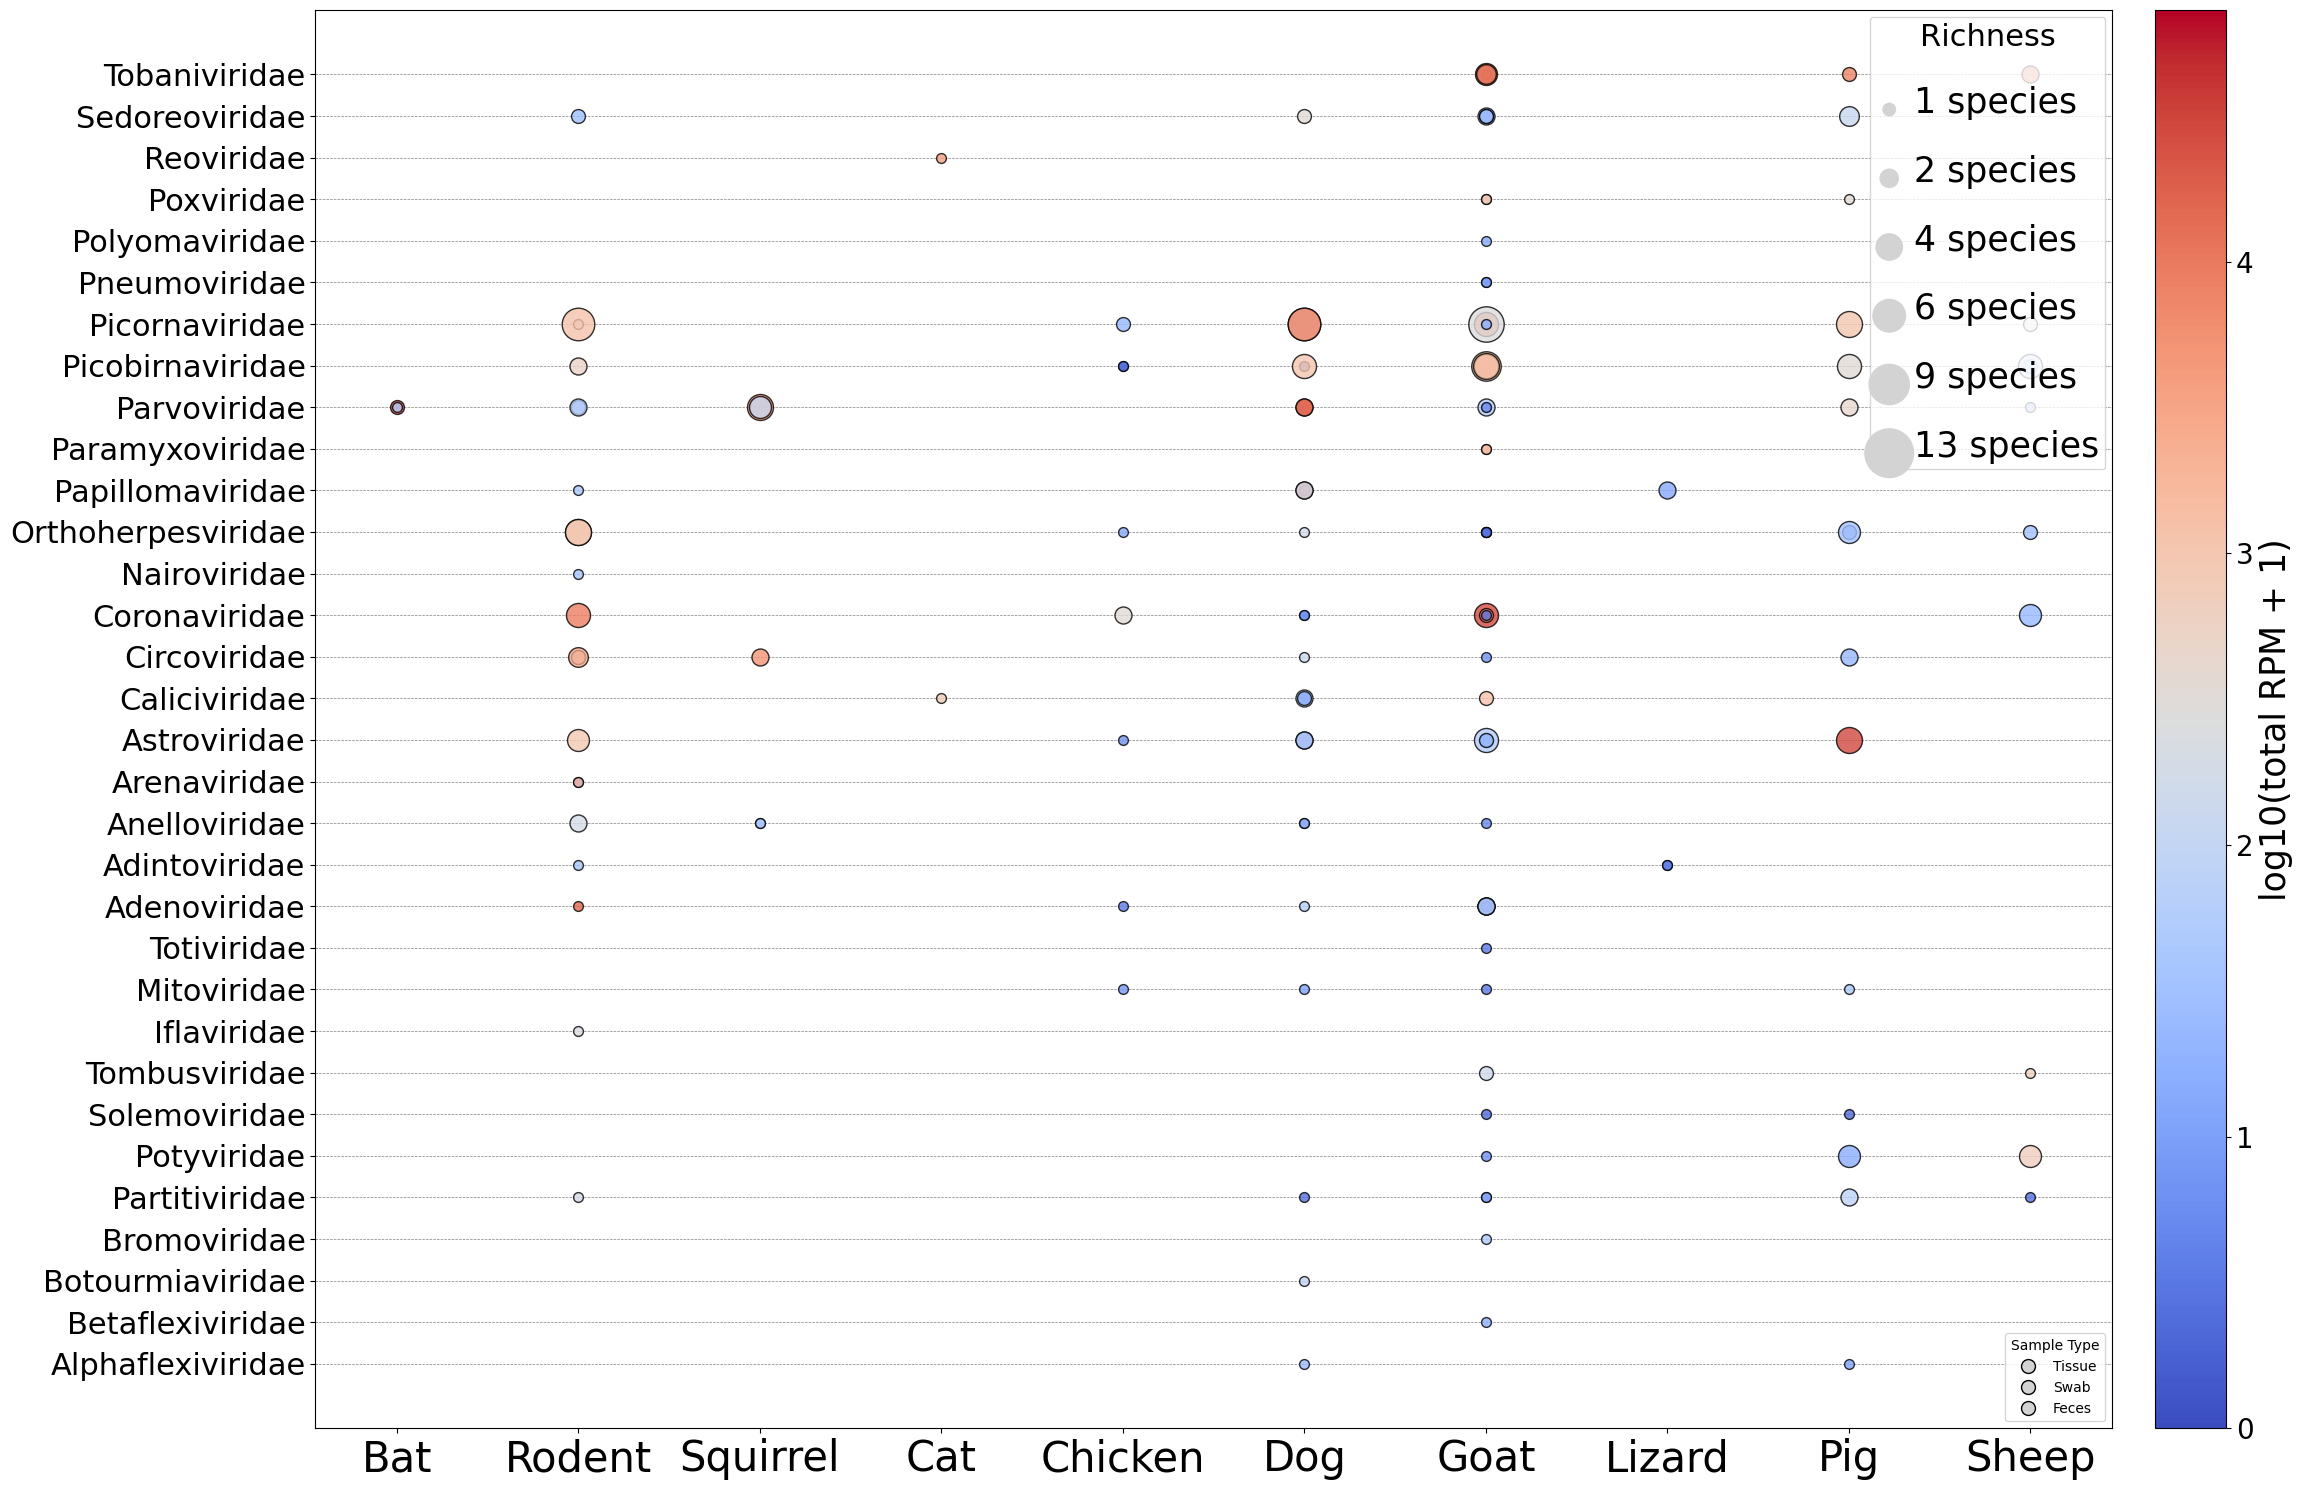

In [5]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Load main data
df = pd.read_csv('./Updated_ALl_Virus_abundance_with_summary.csv')
df = df[df['rpm'] >= 1]

# Load host category info
host_cat = pd.read_csv('./viruses_infecting_category.csv') \
             .rename(columns={'Virus Family': 'family', 'Host Category': 'host_category'})

# Merge host category into main summary
df = df.merge(host_cat, on='family', how='left')

# Summarize per host–family with host category
summary = (
    df.groupby(['ska_species', 'family', 'sample_type', 'Genome', 'collected_by', 'host_category'], as_index=False)
    .agg(
        species_richness=('sci_name', 'nunique'),
        total_RPM=('rpm', 'sum')
    )
)
summary['logRPM'] = np.log10(summary['total_RPM'] + 1)

# Reorder x-axis to put Bat, Lizard, Rodent, Squirrel consecutively
custom_order = ['Bat', 'Rodent', 'Squirrel']
other_hosts = sorted([h for h in summary['ska_species'].unique() if h not in custom_order])
ordered_hosts = custom_order + other_hosts
host_idx = {h: i for i, h in enumerate(ordered_hosts)}

# Group y-axis families by infection host category
cat_priority = ['Plant-infecting', 'Invertebrate-infecting', 'Vertebrate-infecting']
summary['host_category'] = pd.Categorical(summary['host_category'], categories=cat_priority, ordered=True)
families_sorted = (
    summary[['family', 'host_category']]
    .drop_duplicates()
    .sort_values(['host_category', 'family'])
    ['family']
    .tolist()
)
fam_idx = {f: i for i, f in enumerate(families_sorted)}

# Begin plotting
fig, ax = plt.subplots(figsize=(25, 15))
for _, row in summary.iterrows():
    x = host_idx[row['ska_species']]
    y = fam_idx[row['family']]
    size = row['species_richness'] * 50
    color = row['logRPM']
    ax.scatter(
        x, y,
        s=size,
        c=[color],
        cmap='coolwarm',
        vmin=0, vmax=summary['logRPM'].max(),
        marker='o',
        edgecolors='k',
        alpha=0.8
    )

# Colorbar
sm = plt.cm.ScalarMappable(cmap='coolwarm',
                           norm=plt.Normalize(0, summary['logRPM'].max()))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label('log10(total RPM + 1)', size=25)
cbar.ax.tick_params(labelsize=20)

# Axes ticks
ax.set_xticks(range(len(ordered_hosts)))
ax.set_xticklabels(ordered_hosts, rotation=0, ha='center', size=30)
ax.set_yticks(range(len(fam_idx)))
ax.set_yticklabels([f for f in fam_idx.keys()], size=22)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('')

# Horizontal grid
ax.set_axisbelow(True)
ax.yaxis.grid(True, which='major', color='gray', linestyle='--', linewidth=0.5)

# Richness legend
richness_levels = np.unique(summary['species_richness'])
legend_vals = richness_levels if len(richness_levels) <= 6 else richness_levels[np.linspace(0, len(richness_levels)-1, 6, dtype=int)]
for v in legend_vals:
    ax.scatter([], [], s=v*100, c='lightgray', edgecolors='none', label=f'{v} species')
legend1 = ax.legend(scatterpoints=1, frameon=True, title='Richness', labelspacing=2.5, loc='upper right')
legend1.set_title("Richness", prop={'size': 22})
for text in legend1.get_texts():
    text.set_fontsize(25)
ax.add_artist(legend1)

# Sample type legend
shape_map = {'Tissue': 'o', 'Swab': 's', 'Feces': '^'}
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgray', markeredgecolor='k', markersize=10) for _ in shape_map]
labels = list(shape_map.keys())
ax.legend(handles, labels, title='Sample Type', loc='lower right')

# Save
plt.tight_layout()
plt.savefig("./new_Updated_Virome_BubblePlot_ByHostAndCategory.png", dpi=300, bbox_inches="tight")
plt.savefig("./new_Updated_Virome_BubblePlot_ByHostAndCategory.svg", dpi=300, bbox_inches="tight")
plt.show()

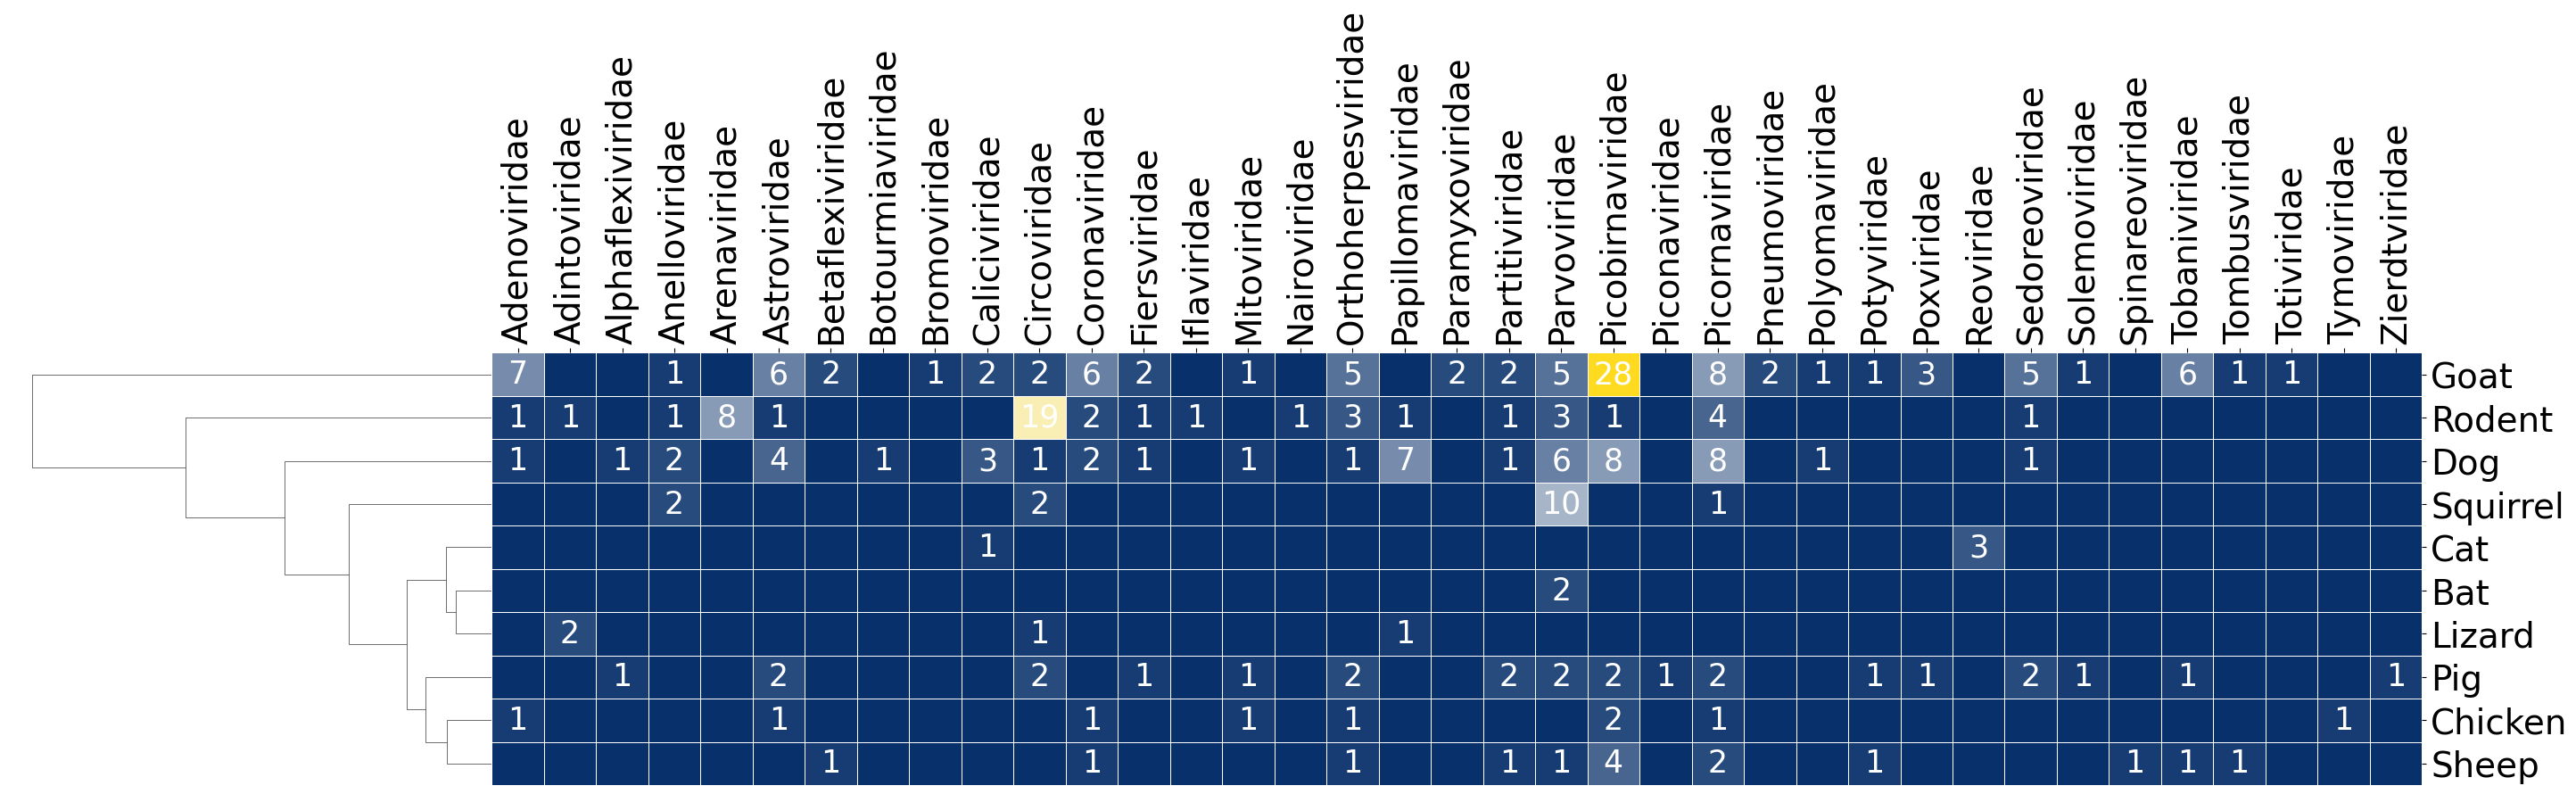

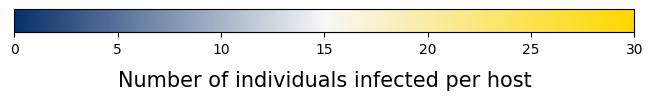

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# For hierarchical clustering
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist

def load_count_data(csv_path):
    """
    Expects a CSV with hosts in the first column (index)
    and viruses in subsequent columns.
    """
    df = pd.read_csv(csv_path)
    df.set_index(df.columns[0], inplace=True)
    return df

def plot_count_heatmap(df, out_prefix="count_heatmap", cluster_rows=True):
    """
    Plots a heatmap of count data with a custom blue→gray→yellow colormap.
    The heatmap is plotted without its default colorbar, and a separate
    figure is created for the colorbar.
    """
    # Transpose the DataFrame so that rows represent viruses
    df = df.T

    # Custom colormap: dark blue (0) → light gray (midpoint) → bright yellow (max)
    cmap = mcolors.LinearSegmentedColormap.from_list(
        "BlueGrayYellow",
        ["#08306B", "#f7f7f7", "#FFD700"],
        N=256
    )

    # Optionally cluster rows (viruses)
    row_linkage = None
    if cluster_rows:
        row_linkage = linkage(pdist(df.values), method='ward')

    # Create a clustermap with no colorbar (cbar_pos=None disables it)
    g = sns.clustermap(
        df,
        row_linkage=row_linkage,
        col_cluster=False,
        cmap=cmap,
        vmin=0,
        vmax=30,
        linewidth=0.5,
        linecolor='white',
        figsize=(28, 8),
        cbar_pos=(0.3, 0.1, 0.4, 0.03)  # Disable default colorbar
    )

    # Annotate each cell with its count value, but skip zeros
    data = g.data2d  # This is the reordered DataFrame used in the heatmap
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            value = data.iloc[i, j]
            if value == 0:
                continue  # Skip annotation for 0
            # The cell centers are at (j+0.5, i+0.5)
            g.ax_heatmap.text(j + 0.5, i + 0.5, int(value),
                              ha='center', va='center',
                              color='white', fontsize=25)

    # Safeguard: only hide the colorbar if it exists
    if g.cax is not None:
        g.cax.set_visible(False)

    # Adjust heatmap labels and positions
    g.ax_heatmap.set_xlabel("", fontsize=25)
    g.ax_heatmap.set_ylabel("", fontsize=25)
    g.ax_heatmap.xaxis.tick_top()
    g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), fontsize=28, rotation=90)
    g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=28)

    # Save the main heatmap figure without the colorbar
    g.fig.savefig(f"{out_prefix}.png", dpi=300, bbox_inches="tight")
    g.fig.savefig(f"{out_prefix}.pdf", dpi=300, bbox_inches="tight")

    # Create a separate figure for the colorbar
    fig_cb, ax_cb = plt.subplots(figsize=(8, 0.3))
    norm = mcolors.Normalize(vmin=0, vmax=30)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Required for older matplotlib versions

    # Create a horizontal colorbar in the separate figure
    cbar = fig_cb.colorbar(sm, cax=ax_cb, orientation="horizontal")
    cbar.set_label("Number of individuals infected per host",fontsize=15, labelpad=10)
    cbar.set_ticks([0, 5, 10, 15, 20,25,30])

    # Save the colorbar figure
    fig_cb.savefig(f"{out_prefix}_colorbar.png", dpi=300, bbox_inches="tight")
    fig_cb.savefig(f"{out_prefix}_colorbar.pdf", dpi=300, bbox_inches="tight")

    plt.show()

def main():
    csv_path = "./1family_vs_ska_species_counts.csv"
    df = load_count_data(csv_path)
    plot_count_heatmap(df, out_prefix="my_figure", cluster_rows=True)

if __name__ == "__main__":
    main()

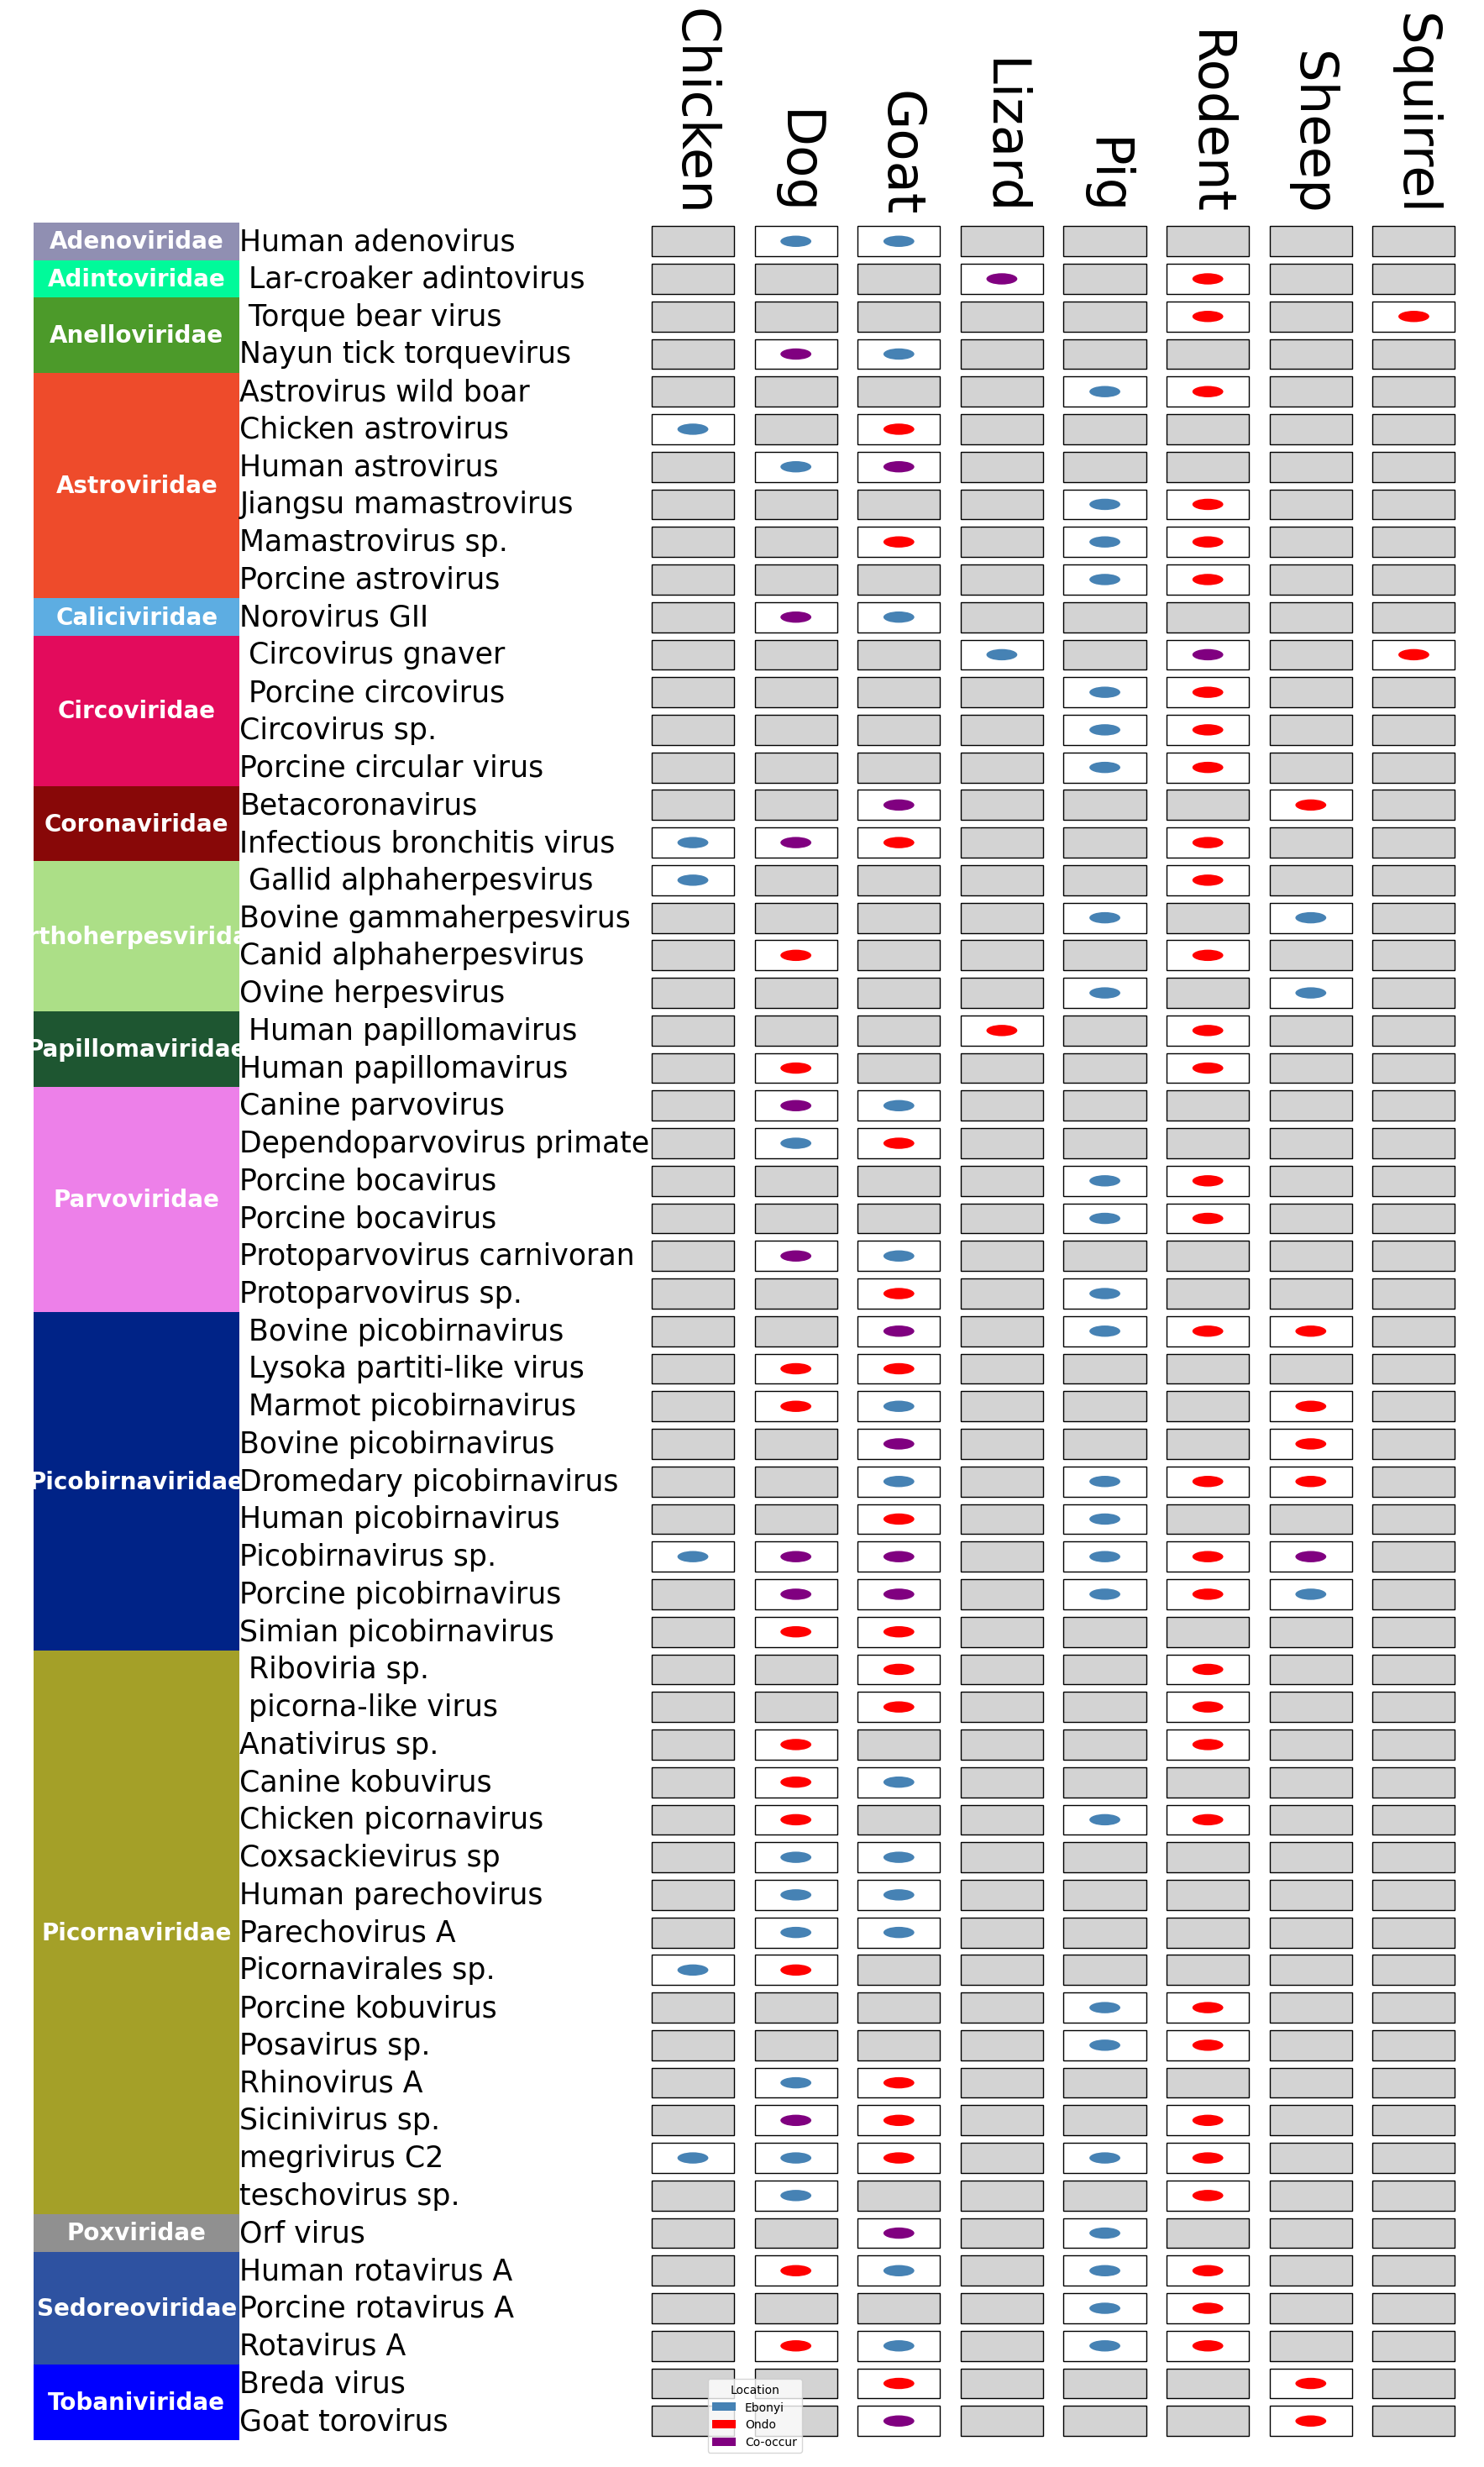

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# -------------------------------------------------------------------
# 1. READ & PREPARE THE DATA
# -------------------------------------------------------------------
# Load the data
df = pd.read_csv("./edited_DNA_RNA_vertebrate_only_counts.csv")

# Mark presence if read_count > 0
df['presence'] = df['read_count'].apply(lambda x: 1 if x > 0 else 0)

# Function to unify virus names
def unify_name(n):
    if "Human adenovirus" in n:
        return "Human adenovirus"
    if "Picobirnavirus sp." in n:
        return "Picobirnavirus sp."
    if "Porcine picobirnavirus" in n:
        return "Porcine picobirnavirus"
    if "Betacoronavirus" in n:
        return "Betacoronavirus"
    if "Dromedary Camel coronavirus" in n:
        return "Dromedary Camel coronavirus"
    if "Porcine bosavirus" in n:
        return "Porcine bosavirus"
    if "Orf virus" in n:
        return "Orf virus"
    return n

    

df['name'] = df['name'].apply(unify_name)

# Clean up location strings (remove extra spaces)
df['collected_by'] = df['collected_by'].str.strip()

# Build a dictionary to track locations for each virus-host pair
location_dict = {}  # (family, name, ska_species) -> set of locations
for _, row in df.iterrows():
    if row['presence'] == 1:
        key = (row['family'], unify_name(row['name']), row['Hosts'])
        location_dict.setdefault(key, set()).add(row['collected_by'])

# Aggregate presence by (name, family, ska_species)
df_agg = df.groupby(['name', 'family', 'Hosts'], as_index=False)['presence'].max()

# Pivot: rows=(family,name), cols=hosts
df_pivot = df_agg.pivot_table(
    index=['family', 'name'],
    columns='Hosts',
    values='presence',
    fill_value=0
).reset_index()

# Remove single-host viruses (optional)
host_cols = [c for c in df_pivot.columns if c not in ('family', 'name')]
df_pivot['host_count'] = df_pivot[host_cols].sum(axis=1)
df_pivot = df_pivot[df_pivot['host_count'] > 1]
df_pivot.drop(columns='host_count', inplace=True)

# Remove empty host columns
hosts_to_keep = [h for h in host_cols if df_pivot[h].sum() > 0]
df_pivot = df_pivot[['family', 'name'] + hosts_to_keep]

# Sort and reset index
df_pivot.sort_values(by=['family', 'name'], inplace=True)
df_pivot.reset_index(drop=True, inplace=True)

# -------------------------------------------------------------------
# 2. OPTIONAL: READ A FAMILY->COLOR MAP
# -------------------------------------------------------------------
try:
    color_df = pd.read_csv("./fig3_color_palette.txt", sep="\t", header=None, names=["key", "color"])
    family_color_map = dict(zip(color_df["key"], color_df["color"]))
except:
    family_color_map = {}
default_color = "#CCCCCC"

# -------------------------------------------------------------------
# 3. SETUP FIGURE
# -------------------------------------------------------------------
num_rows = len(df_pivot)
num_hosts = len(hosts_to_keep)
fig_width = 18
fig_height = max(4, 0.5 * num_rows)

fig, ax = plt.subplots(figsize=(fig_width, fig_height))
ax.set_xlim([0, num_hosts + 6])
ax.set_ylim([0, num_rows + 1])
ax.invert_yaxis()
ax.axis('off')

# -------------------------------------------------------------------
# 4. DRAW A VERTICAL COLORED BAR PER FAMILY
# -------------------------------------------------------------------
family_groups = df_pivot.groupby('family').groups
bar_left = 0.0
bar_width = 2.0

for fam, indices in family_groups.items():
    row_min = min(indices)
    row_max = max(indices)
    top = row_min + 0.5
    bottom = row_max + 1.5
    height = bottom - top
    
    color_for_fam = family_color_map.get(fam, default_color)
    rect = patches.Rectangle(
        (bar_left, top),
        bar_width,
        height,
        facecolor=color_for_fam,
        edgecolor='none'
    )
    ax.add_patch(rect)
    
    ax.text(
        bar_left + bar_width / 2,
        (top + bottom) / 2,
        fam,
        ha='center', va='center',
        fontsize=20, fontweight='bold',
        color='white'
    )

# -------------------------------------------------------------------
# 5. DRAW VIRUS NAMES & PRESENCE BOXES
# -------------------------------------------------------------------
virus_name_x = 2
start_box_x = 6

for i, row in df_pivot.iterrows():
    y_center = i + 1
    fam = row['family']
    virus_name = row['name']
    
    ax.text(
        virus_name_x, y_center,
        virus_name,
        ha='left', va='center',
        fontsize=25
    )
    
    for j, host in enumerate(hosts_to_keep):
        presence = row[host]
        x_left = start_box_x + j
        box_size = 0.8
        y_bottom = y_center - box_size / 2
        
        fill_color = 'white' if presence == 1 else 'lightgrey'
        rect = patches.Rectangle(
            (x_left, y_bottom),
            box_size, box_size,
            facecolor=fill_color,
            edgecolor='black',
            linewidth=1
        )
        ax.add_patch(rect)
        
        if presence == 1:
            # Look up location(s) for this (fam, virus_name, host)
            key = (fam, virus_name, host)
            locs = location_dict.get(key, set())
            
            # Decide dot color
            if "Ebonyi" in locs and "Ondo" in locs:
                circle_color = "purple"
            elif "Ebonyi" in locs:
                circle_color = "steelblue"
            elif "Ondo" in locs:
                circle_color = "red"
            else:
                circle_color = "dodgerblue"
            
            circle = patches.Circle(
                (x_left + box_size / 2, y_center),
                radius=0.15,
                facecolor=circle_color,
                edgecolor='none'
            )
            ax.add_patch(circle)

# -------------------------------------------------------------------
# 6. ADD HOST HEADERS
# -------------------------------------------------------------------
header_y = 0.3
for j, host in enumerate(hosts_to_keep):
    x_center = start_box_x + j + box_size / 2
    ax.text(
        x_center, header_y,
        host,
        ha='center', va='bottom',
        rotation=270, fontsize=45
    )

# -------------------------------------------------------------------
# 7. ADD LEGEND FOR LOCATIONS
# -------------------------------------------------------------------
import matplotlib.patches as mpatches

legend_elements = [
    mpatches.Patch(facecolor='steelblue', edgecolor='none', label='Ebonyi'),
    mpatches.Patch(facecolor='red', edgecolor='none', label='Ondo'),
    mpatches.Patch(facecolor='purple', edgecolor='none', label='Co-occur')
]
ax.legend(handles=legend_elements, loc='lower center', title='Location')

# -------------------------------------------------------------------
# 8. SAVE & SHOW
# -------------------------------------------------------------------
plt.title("", pad=20, fontsize=20)
plt.tight_layout()
plt.savefig("./vertebrate_vertical_family_bar_plot.png", dpi=300)
plt.savefig("./vertebrate_vertical_family_bar_plot.svg", dpi=300)

plt.show()